# Understanding Contamination Bias

*Problems and solutions of linear regression with multiple treatments*

In many causal inference settings, we might be interested in the effect of not just one treatment, but **many mutually exclusive treatments**. For example, we might want to test different alternative UX designs, or different alternative drugs, or policies. Depending on the context, there might be many reasons why we want to test different treatments at the same time, but generally it can help *reducing the sample size*, as we need just a single control group. A simple way to recover the different treatment effects is a linear regression of the outcome of interest on the different treatment indicators.

However, in causal inference, we often **condition the analysis** on other observable variables (often called control variables), either to increase power or, especially in quasi-experimental settings, to identify a causal parameter instead of a simple correlation. There are [cases in which adding control variables can backfire](https://towardsdatascience.com/b63dc69e3d8c), but otherwise, we usually think that the regression framework is still able to recover the average treatment effect.

In a breakthrough paper, [Goldsmith-Pinkham, Hull and Kolesár (2022)](https://www.nber.org/papers/w30108) have recently shown that in case of *multiple and mutually-exclusive* treatments with *control variables*, the **regression coefficients do not identify a causal effect**. However, not everything is lost: the authors propose a simple solution to this problem that still makes use of linear regression.

In this blog post, I am going to go through a **simple example** illustrating the nature of the problem and the solution proposed by the authors. 

## Multiple Treatments Example

Suppose we are an online store and we are not satisfied with our current *checkout page*. In particular, we would like to change our **checkout button** to increase the probability of a purchase. Our UX designer comes up with two alternative checkout buttons, which are displayed below.

<img src="fig/buttons.png" width="800px"/>

In order to understand which button to use, we run an [**A/B test**](https://en.wikipedia.org/wiki/A/B_testing), or randomized control trial. In particular, when people arrive at the checkout page, we show them one of the three options, at random. Then, for each user, we record the revenue generated which is our outcome of interest.

I generate a synthetic dataset using `dgp_buttons()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/dgp.py) as data generating process. I also import plotting functions and standard libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_buttons

In [3]:
dgp = dgp_buttons()
df = dgp.generate_data()
df.head()

,group,revenue,mobile
0,button1,8.927335,0
1,default,13.613456,1
2,button2,4.777628,0
3,default,8.909049,0
4,default,10.160347,0


We have information on 2000 users, for which we observe their checkout button (`default`, `button1` or `button2`), the `revenue` they generate and whether they connected from desktop or `mobile`. 

We notice too late that we have a **problem with randomization**. We showed `button1` more frequently to desktop users and `button2` more frequently to mobile users. The control group that sees the `default` button instead is balanced.

<img src="fig/randomization.png" width="600px"/>

What should we do? What happens if we simply compare `revenue` across `groups`? Let's do it by regressing `revenue` on `group` dummy variables.

In [4]:
smf.ols('revenue ~ group', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6553,0.149,78.250,0.000,11.363,11.948
group[T.button1],-0.5802,0.227,-2.556,0.011,-1.026,-0.135
group[T.button2],-0.5958,0.218,-2.727,0.006,-1.024,-0.167


From the regression results we estimate a negative and significant effect for both buttons. Should we believe these estimates? Are they **causal**?

It is unlikely that what we have estimated are the true treatment effects. In fact, there might be substantial **differences in purchase attitudes** between desktop and mobile users. Since we do not have a comparable number of mobile and desktop users across treatment arms, it might be that the observed differences in `revenue` are due to the *device* used and not the *button design*.

Because of this, we decide to **condition** our analysis on the device used and we include the `mobile` dummy variable in the regression.

In [5]:
smf.ols('revenue ~ group + mobile', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.1414,0.110,82.905,0.000,8.925,9.358
group[T.button1],0.3609,0.141,2.558,0.011,0.084,0.638
group[T.button2],-1.0326,0.134,-7.684,0.000,-1.296,-0.769
mobile,4.7181,0.116,40.691,0.000,4.491,4.946


Now the coefficient of `button1` is positive and significant. Should we recommend its implementation?

The answer is **surprisingly no**. [Goldsmith-Pinkham, Hull, Kolesár (2022)](https://www.nber.org/papers/w30108) show that this type of regression does not identify the average treatment effect when:

- there are mutually exclusive treatment arms (in our case, `groups`)
- we are controlling for some variable $X$ (in our case, `mobile`)
- there treatment effects are heterogeneous in $X$

This is true **even if** the treatment is "as good as random" once we condition on $X$. 

Indeed, in our case, the true treatment effects are the ones reported in the following table.

<img src="fig/effects.png" width="500px"/>

The first button has **no effect** on revenue, irrespectively of the device, while the second button has a **positive effect** for mobile users and a **negative effect** for desktop users. Our (wrong) regression specification instead estimates a positive effect of the first button.

Let's now dig more in detail into the math, to understand why this is happening.

## Theory

This section heavily borrows from [Goldsmith-Pinkham, Hull, Kolesár (2022)](https://www.nber.org/papers/w30108). For a very synthetic but precise summary of the paper, I recommend this excellent Twitter thread by one of the authors, Paul Goldsmith-Pinkham.

{{< tweet 1534169803388293120 >}}

### Single Treatment Arm

Suppose we are interested in the effect of a treatment $D$ on an outcome $Y$. First, let's consider the standard case of a **single treatment arm** so that the treatment variable is binary, $D \in \lbrace 0 , 1 \rbrace$. Also consider a single **binary control variable** $X \in \lbrace 0 , 1 \rbrace$. We also assume that treatment is as good as random, conditionally on $X$. This means that there might be systematic differences between the treatment and control group, however, these differences are fully accounted for by $X$. Formally we write

$$
\left( Y_i^{(0)}, Y_i^{(1)} \right) \ \perp \ D_i \ | \ X_i
$$

Where $Y_i^{(d)}$ denotes the potential outcome of individual $i$ when its treatment status is $d$. For example, $Y_i^{(0)}$ indicates the outcome of individual $i$ in case it is not treated. This notation comes from [Rubin's potential outcomes framework](https://www.tandfonline.com/doi/abs/10.1198/016214504000001880). We can write the **individual treatment effect** of individual $i$ as

$$
\tau_i = Y_i^{(1)} - Y_i^{(0)}
$$

In this setting, the **regression of interest** is

$$
Y = \alpha + \beta D + \gamma X + u
$$

The coefficient of interest is $\beta$. 

[Angrist (1998)](https://www.jstor.org/stable/2998558) shows that **the regression coefficient identifies the average treatment effect**. In particular, the regression coefficient identifies a weighted average of the within-group average treatment effect with convex weights. In this particular setting, we can write it as

$$
\beta = \lambda \tau(0) + (1 - \lambda) \tau(1) \qquad \text{where} \qquad \tau (x) = \mathbb E \big[ Y_i^{(1)} - Y_i^{(0)} \ \big| \ X_i = x \big]
$$

The weights are given by the within-group treatment variance. Hence, the OLS estimator gives **less weight to groups where we have less treatment variance**, i.e., where treatment is more imbalanced. Groups where treatment is distributed 50-50 get the most weight.

$$
\lambda = \frac{ \text{Var} \big(D_i \ \big| \ X_i = 0 \big) \Pr \big(X_i=0 \big)}{\sum_{x \in \lbrace 0 , 1 \rbrace} \text{Var} \big(D_i \ \big| \ X_i = x \big) \Pr \big( X_i=x \big)} \in [0, 1]
$$

The weights can be derived using the [Frisch-Waugh-Lowell theorem](https://towardsdatascience.com/59f801eb3299) to express $\beta_1$ as the OLS estimate of a univariate regression of $Y$ on $D_{i, \perp X}$, where $D_{i, \perp X}$ are the residuals from regressing $D$ on $X$. If you are not familiar with the Frisch-Waugh-Lowell theorem, I wrote an [introductory blog post here](https://towardsdatascience.com/59f801eb3299).

$$
\beta_1 = \frac{ \mathbb E \big[ D_{i, \perp X} Y_i \big] }{ \mathbb E \big[ D_{i, \perp X}^2 \big] } = 
\underbrace{ \frac{\mathbb E \big[ D_{i, \perp X} Y_i(0) \big]}{\mathbb E \big[ D_{i, \perp X}^2 \big]} } _ {=0} + \frac{\mathbb E \big[ D_{i, \perp X} D_i \tau_i \big]}{\mathbb E \big[ D_{i, \perp X}^2 \big]} =
\frac{\mathbb E \big[ \text{Var} (D_i | X_i) \ \tau(X_i) \big]}{\mathbb E \big[ \text{Var}(D_i | X_i) \big]}
$$

The second term disappears because the residual $D_{i, \perp X}$ is by construction **mean independent** of the control $X_i$, i.e. $\mathbb E \big[ D_{i, \perp X} | X_i \big] = 0$. This mean independence property is crucial to obtain an unbiased estimate and its failures in the multiple-treatment case is the source of the *contamination bias*.

### Multiple Treatment Arms

Let's now consider the case of multiple treatment arms, $D \in \lbrace 0 , 1, 2 \rbrace$. We still assume **conditional ignorability**, i.e., the treatment is as good as random, conditional on $X$.

$$
\left( Y_i^{(0)}, Y_i^{(1)}, Y_i^{(2)} \right) \ \perp \ D_i \ | \ X_i
$$

In this case, we have two different **individual treatment effects**, one per treatment.

$$
\tau_{i1} = Y_i^{(1)} - Y_i^{(0)} \qquad \text{and} \qquad \tau_{i2} = Y_i^{(2)} - Y_i^{(0)}
$$

The **regression of interest** is

$$
Y = \alpha + \beta_1 D_1 + \beta_2 D_2 + \gamma X + u
$$

Does the OLS estimator **identify** $\beta_1$ and $\beta_2$? 

It would be very tempting to say yes. In fact, it looks like not much has changed. We just have one extra treatment, but the potential outcomes are still conditionally independent of it. Where is the **issue**?

Let's concentrate on $\beta_1$ (the same applies to $\beta_2$). As before, can rewrite $\beta_1$ using the [Frisch-Waugh-Lowell theorem](https://towardsdatascience.com/59f801eb3299) as the OLS coefficient of a univariate regression of $Y_i$ on $D_{i1, \perp X, D_2}$, where $D_{i1, \perp X, D_2}$ are the residuals from regressing $D_1$ on $D_2$ and $X$. 

$$
\beta_1 = \frac{ \mathbb E \big[D_{i1, \perp X, D_2} Y_i \big] }{ \mathbb E \big[ D_{i1, \perp X, D_2}^2 \big]} = \underbrace{ \frac{ \mathbb E \big[ D_{i1, \perp X, D_2} Y_i(0) \big] }{\mathbb E \big[ D_{i1, \perp X, D_2}^2 \big]} } _ {=0} + \frac{ \mathbb E \big[ D_{i1, \perp X, D_2} D_{i1} \tau_{i1} \big] }{ \mathbb E \big[ D_{i1, \perp X, D_2}^2 \big]} + \color{red}{ \underbrace{ \color{black}{ \frac{ \mathbb E \big[ D_{i1, \perp X, D_2} D_{i2} \tau_{i2} \big] }{ \mathbb E \big[ D_{i1, \perp X, D_2}^2 \big]}} } _ { \neq 0} }
$$

The **problem** is the last term. Without the last term, we could still write $\beta_1$ as a convex combination of the individual treatment effects. However, the last term biases the estimator by adding a component that depends on **the treatment effect of $D_2$**, $\tau_2$. Why does this term not disappear?

The problem is that $D_{i1, \perp X, D_2}$ is not mean independent of $D_{i2}$, i.e. 

$$
\mathbb E \big[ D_{i1, \perp X, D_2} D_{i2} \ \big| \ X_i \big] \neq 0
$$

The reason lies in the fact that the treatments are **mutually exclusive**. This implies that when $D_{i1}=1$, $D_{i2}$ must be zero, regardless of the value of $X_i$. Therefore, the last term does not cancel out and it introduces a **contamination bias**.

### Solution

[Goldsmith-Pinkham, Hull, Kolesár (2022)](https://www.nber.org/papers/w30108) show that a **simple estimator**, first proposed by [Imbens and Wooldridge (2009)](https://www.aeaweb.org/articles?id=10.1257/jel.47.1.5) is able to remove the bias. The procedure is the following.

1. De-mean the control variable: $\tilde X = X - \bar X$
2. Regress $Y$ on the interaction between the treatment indicators $D$ and the demeaned control variable $\tilde X$

This estimator is an **unbiased** estimator of the average treatment effect. It also just requires a linear regression. Moreover, this estimator is unbiased also for continuous control variables $X$, not only for a binary one as we have considered so far. 

## Simulations

In order to better understand both the problem and the solution, let's run some **simulations**.

We run an estimator over different draws from the data generating process `dgp_buttons()`. This is only possible with synthetic data and we do not have this luxury in reality. For each sample, we record the estimated coefficient and the corresponding [p-value](https://en.wikipedia.org/wiki/P-value).

In [6]:
def simulate(dgp, estimator, K=1000):
    
    # Initialize coefficients
    results = pd.DataFrame({'Coefficient': np.zeros(K), 'pvalue': np.zeros(K)})
    
    # Compute coefficients
    for k in range(K):
        df = dgp.generate_data(seed=k)
        results.Coefficient[k] = estimator(df).params[1]
        results.pvalue[k] = estimator(df).pvalues[1]
    
    results['Significant'] = results['pvalue'] < 0.05
    return results

First, let's try it with the old estimator that regresses `revenue` on both `group` and `mobile` dummy variables.

In [7]:
ols_estimator = lambda x: smf.ols('revenue ~ group + mobile', data=x).fit()
results = simulate(dgp, ols_estimator)

I **plot** the distribution of the coefficient estimates of `button1` over 1000 simulations, highlighting the statistically significant ones at the 5% level. I also highlight the true value of the coefficient, zero, with a vertical dotted bar.

In [8]:
def plot_results(results):
    p_sig = sum(results['Significant']) / len(results) * 100
    sns.histplot(data=results, x="Coefficient", hue="Significant", multiple="stack", 
                 palette = ['tab:red', 'tab:green']);
    plt.axvline(x=0, c='k', ls='--', label='truth')
    plt.title(rf"Estimated $\beta_1$ ({p_sig:.0f}% significant)");

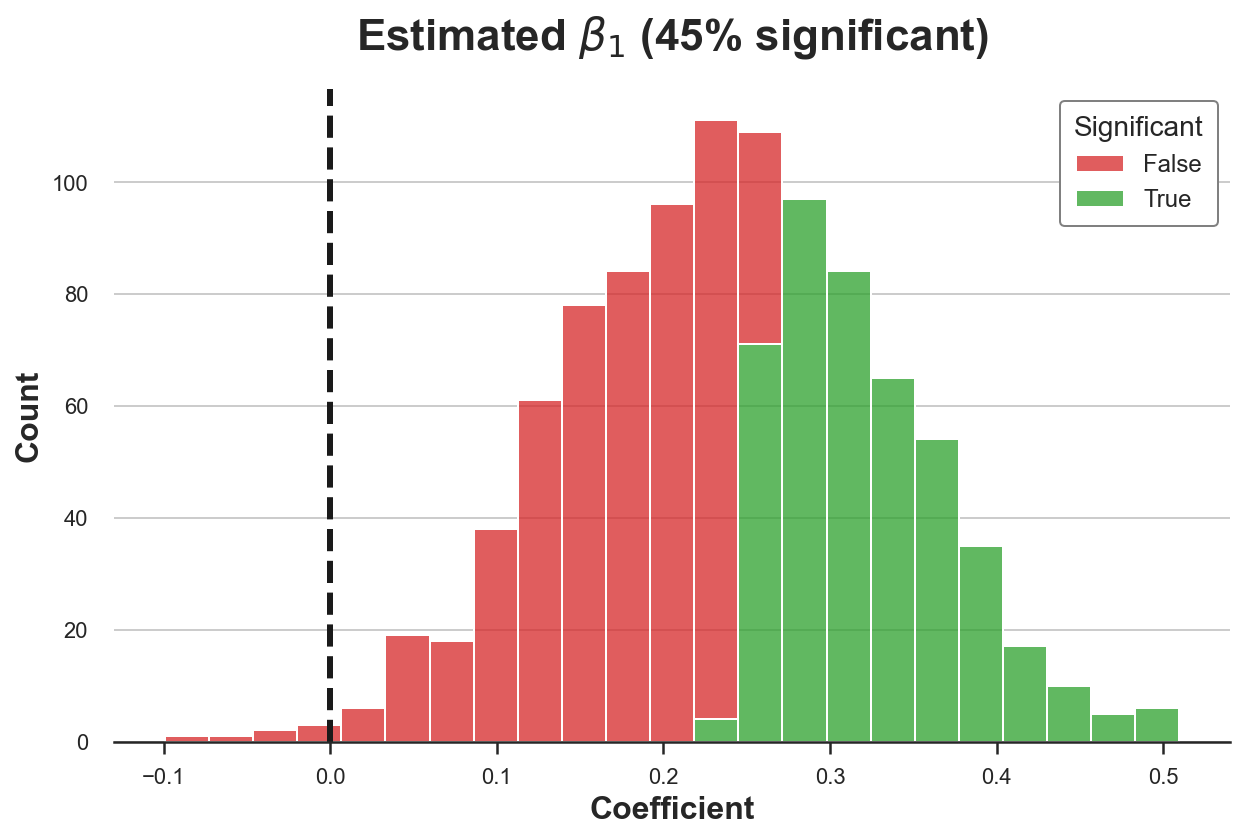

In [9]:
plot_results(results)

As we can see, we reject the null hypothesis of no effect of `button1` in 45% of the simulations. Since we set a confidence level of 5%, we would have expected at most around 5% of rejections. Our estimator is **biased**.

As we have seen above, the problem is that the estimator is not just a convex combination of the effect of `button1` across mobile and desktop users (it's zero for both), but it is **contaminated** by the effect of `button2`.

Let's now try the new estimator proposed by [Goldsmith-Pinkham, Hull, Kolesár (2022)](https://www.nber.org/papers/w30108). First, we need do de-mean our control variable, `mobile`. Then, we regress `revenue` on the interaction between `group` and the de-meaned control variable, `res_mobile`.

In [10]:
df['mobile_res'] = df['mobile'] - np.mean(df['mobile'])
smf.ols('revenue ~ group * mobile_res', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.5773,0.067,172.864,0.000,11.446,11.709
group[T.button1],0.0281,0.106,0.266,0.790,-0.180,0.236
group[T.button2],-1.5071,0.100,-15.112,0.000,-1.703,-1.311
mobile_res,2.9107,0.134,21.715,0.000,2.648,3.174
group[T.button1]:mobile_res,0.1605,0.211,0.760,0.448,-0.254,0.575
group[T.button2]:mobile_res,5.3771,0.200,26.905,0.000,4.985,5.769


The estimated coefficients are now **close to their true values**. The estimated coefficient for `button1` is not significant, while the estimated coefficient for `button2` is positive and significant.

Let's check whether this results holds **across samples** by running a simulation. We repeat the estimation procedure 1000 times and we plot the distribution of estimated coefficients for `button1`.

In [11]:
new_estimator = lambda x: smf.ols('revenue ~ group * mobile', data=x).fit()
new_results = simulate(dgp, new_estimator)

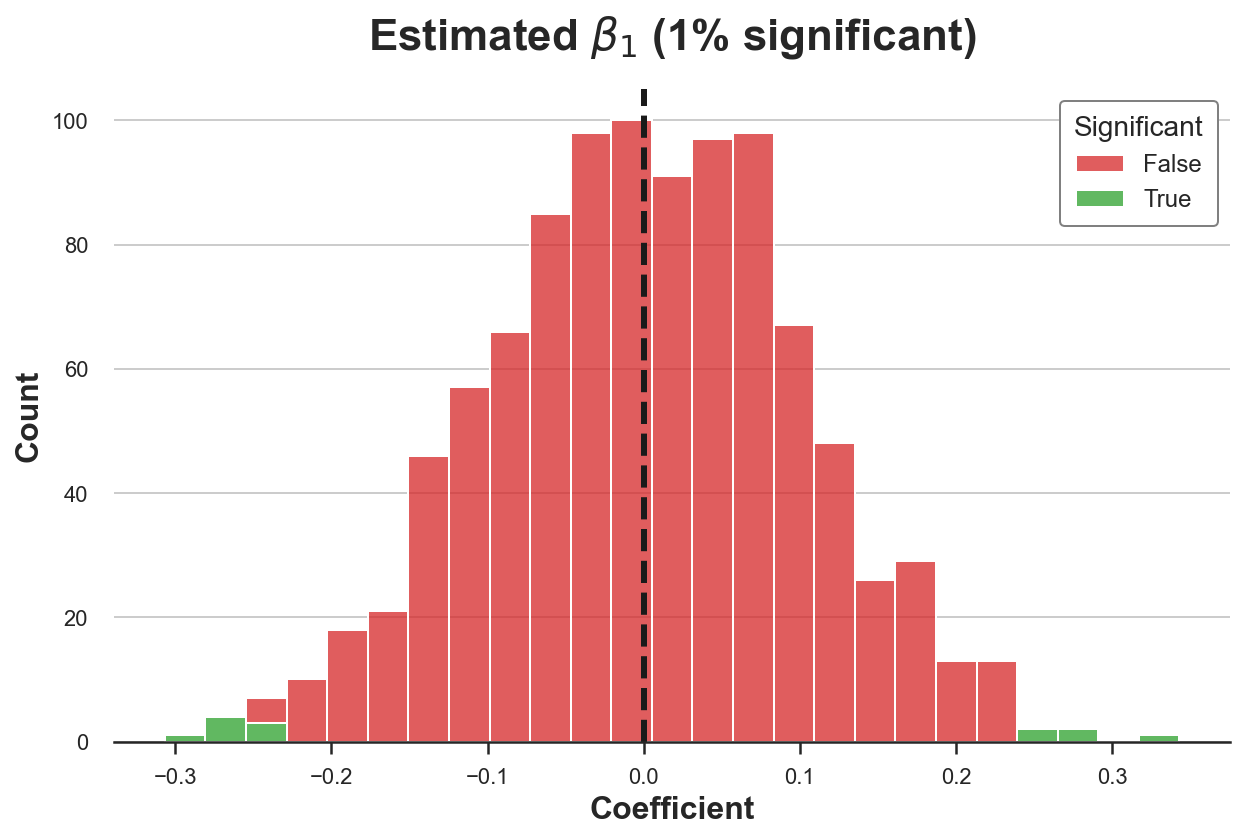

In [12]:
plot_results(new_results)

Now the distribution of the estimated coefficient for the first alternative button is centered around the true value of zeros. Moreover, we reject the null hypothesis of no effect only in 1% of the simulations, consistently with the chosen confidence level of 95%.

## Conclusion

In this post, we have seen the dangers of running a factor regression model with multiple *mutually exclusive* treatment arms and treatment effect heterogeneity across a control variable. In this case, because the treatments are not independent, the regression coefficient is not a convex combination of the within-group average treatment effects, but also captures the treatment effects of the other treatments introducing **contamination bias**. The solution to the problem is both simple and elegant, requiring just a linear regression.

However, **the problem is more general** than this setting and generally concerns every setting in which

1. We have multiple treatments that depend on each other
2. We need to condition the analysis on a control variable
3. The treatment effects are heterogeneous in the control variable

Another popular example is the case of the [Two-Way Fixed Effects (TWFE) estimator with staggered treatments](https://arxiv.org/abs/2201.01194).

### References

[1] J. Angrist, [Estimating the Labor Market Impact of Voluntary Military Service Using Social Security Data on Military Applicants](https://www.jstor.org/stable/2998558) (1998), *Econometrica*.

[2] D. Rubin, [Causal Inference Using Potential Outcomes](https://www.tandfonline.com/doi/abs/10.1198/016214504000001880) (2005), *Journal of the American Statistical Association*.

[3] G. Imbens, J. Wooldridge, [Recent Developments in the Econometrics of Program Evaluation](https://www.aeaweb.org/articles?id=10.1257/jel.47.1.5) (2009), *Journal of Economic Literature*.

[4] P. Goldsmith-Pinkham, P. Hull, M. Kolesár, [Contamination Bias in Linear Regressions](https://www.nber.org/papers/w30108) (2022), *working paper*.

### Related Articles

- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)
- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/cbias.ipynb